In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
#pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import statsmodels.api as sm
import seaborn as sb
from sklearn.linear_model import BayesianRidge, LinearRegression
import sklearn.metrics as metrics
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#read csv and make index the date
df = pd.read_csv("coinbaseUSD.csv", names = ["date", "price", "amount"], index_col = "date")

In [3]:
# convert index from unix to regular timestamp
df.index = pd.to_datetime(df.index, unit = 's')
df.dropna()
# take just a sample to speed it up for now
start_test = datetime.datetime(2016,1,1)
df = df[df.index > start_test]

In [4]:
# resample to minutes and forward fill
# this is a good assumption because the price will not have changed
df_res = df.resample("T").mean().ffill()
df_res.head()

,price,amount
date,,
2016-01-01 00:00:00,430.3725,0.018175
2016-01-01 00:01:00,430.3900,0.157967
2016-01-01 00:02:00,430.4000,0.816700
2016-01-01 00:03:00,430.3780,2.513260
2016-01-01 00:04:00,430.3900,1.953000


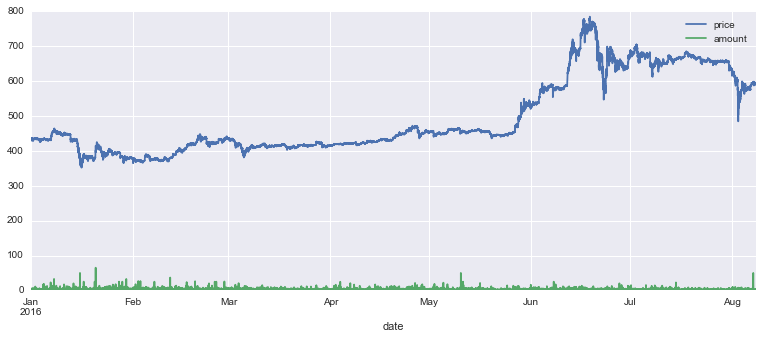

In [5]:
df_res.plot(figsize=(13, 5))

In [6]:
#check the autocorrelations
print df_res['price'].autocorr(lag=1)
print df_res['amount'].autocorr(lag=1)

0.999992683795
0.243949684712


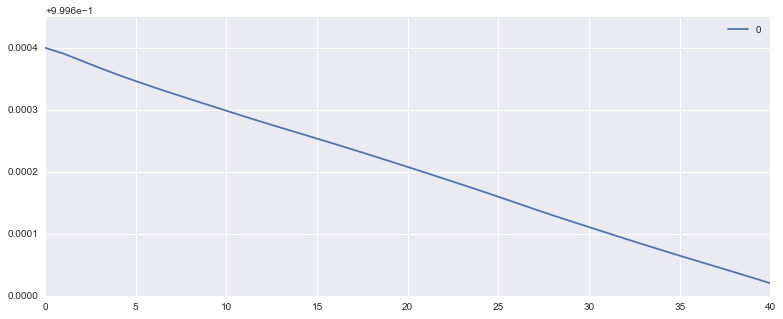

In [7]:
from statsmodels.tsa.stattools import acf
pd.DataFrame(acf(df_res.price, nlags=40, fft=True)).plot(figsize=(13, 5))

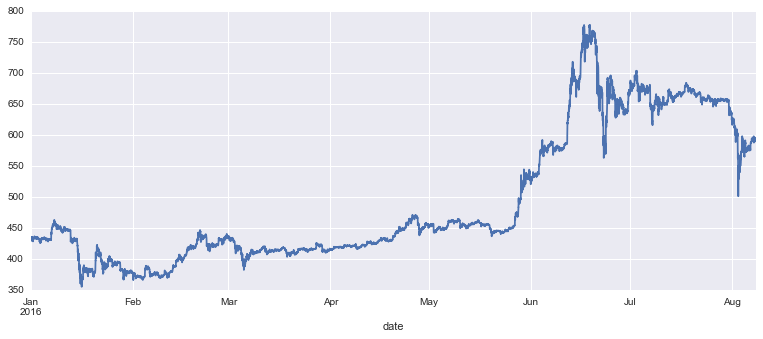

In [8]:
#rolling mean
df_res.price.rolling(window=20, center=False).mean().plot(figsize=(13, 5));

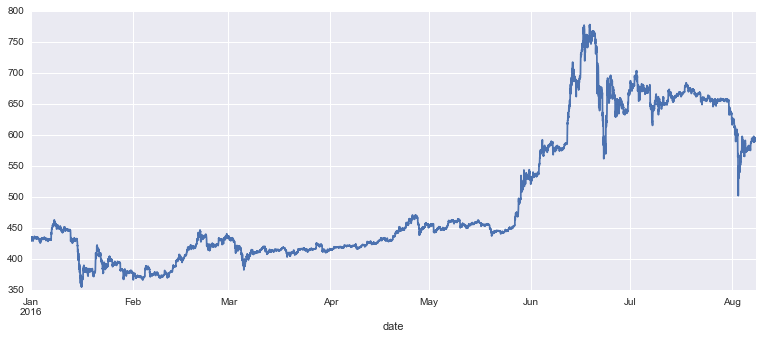

In [9]:
#exponentialy weighted mean
df_res.price.ewm(ignore_na=False, span=20, min_periods=0, adjust=True).mean().plot(figsize=(13,5));

In [10]:
#function to create lags, default 5 lags with price change from last period
def create_lagged_series(ts, lags=5):

    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag["price"] = ts["price"]
    #tslag["amount"] = ts["amount"]

    # Create the shifted lag series of prior values
    for i in xrange(0,lags):
        tslag["Lag%s" % str(i+1)] = ts["price"].shift(i+1)

    # Create the diff DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    #tsret["amount"] = tslag["amount"]
    tsret["price_delta"] = tslag["price"].diff()

    # If any of the values  equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(tsret["price_delta"]):
        if (abs(x) < 0.00001):
            tsret["price_delta"][i] = 0.00001

    # Create the lagged price difference columns
    for i in xrange(0,lags):
        tsret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)].diff()

    # Create the "Direction" column (+1 or -1) indicating an up/down day
    # DIRECTION MUST BE DIRECTION OF CURRENT PRICE FROM LAST DROPPED LAG
    #MAY NEED SEPARATE FUNCTION
    tsret["Direction"] = np.sign(tsret["price_delta"])
    tslag["Direction"] = np.sign(tsret["price_delta"])
 
    #return both the diffs and regular lags, just in case
    return tsret, tslag

In [11]:
# create lags of diffs and prices
df_diff, df_lag = create_lagged_series(df_res, 10)
df_diff = df_diff.dropna()
df_lag = df_lag.dropna()
#df_lag.to_csv("btc_120lags_10s.csv")

In [12]:
df_diff.tail()

,price_delta,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Direction
date,,,,,,,,,,,,
2016-08-08 11:56:00,0.010000,-0.143333,0.090000,0.042000,0.095500,0.054239,-0.315489,0.076509,0.219741,-0.001250,0.056750,1.0
2016-08-08 11:57:00,0.023333,0.010000,-0.143333,0.090000,0.042000,0.095500,0.054239,-0.315489,0.076509,0.219741,-0.001250,1.0
2016-08-08 11:58:00,0.010000,0.023333,0.010000,-0.143333,0.090000,0.042000,0.095500,0.054239,-0.315489,0.076509,0.219741,1.0
2016-08-08 11:59:00,0.003333,0.010000,0.023333,0.010000,-0.143333,0.090000,0.042000,0.095500,0.054239,-0.315489,0.076509,1.0
2016-08-08 12:00:00,-0.056667,0.003333,0.010000,0.023333,0.010000,-0.143333,0.090000,0.042000,0.095500,0.054239,-0.315489,-1.0


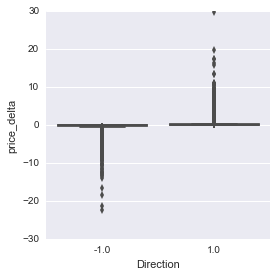

In [13]:
#This does not tell us too much, but gives a good idea of the range
sb.factorplot(x = 'Direction', y = 'price_delta',data = df_diff, kind = 'box')

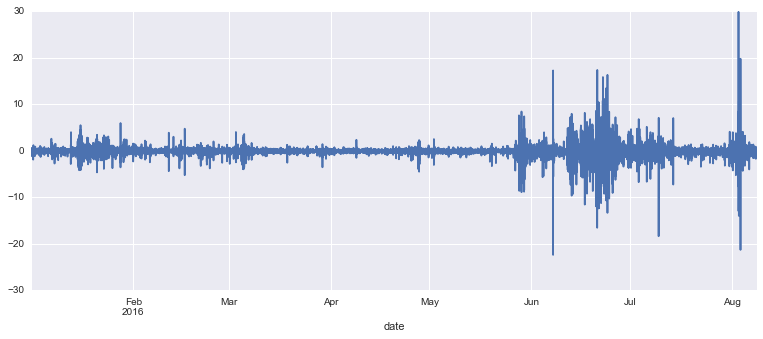

In [14]:
#plot the differenced data
df_diff.price_delta.plot(figsize=(13, 5))

In [15]:
# check the autocorrelation - much less than just using the price
print df_diff['price_delta'].autocorr(lag=1)

0.161561449123


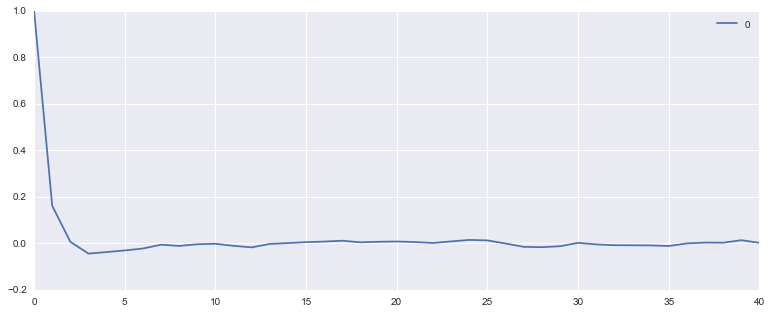

In [16]:
pd.DataFrame(acf(df_diff.price_delta, nlags=40, fft=True)).plot(figsize=(13, 5))

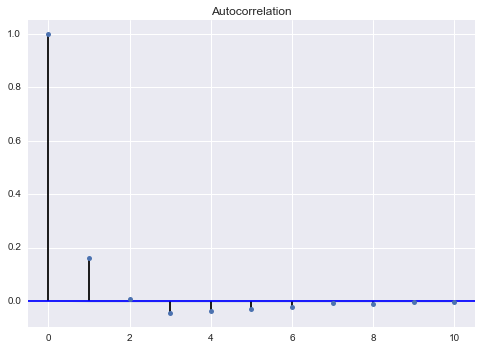

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff.price_delta, lags=10)
plt.show()

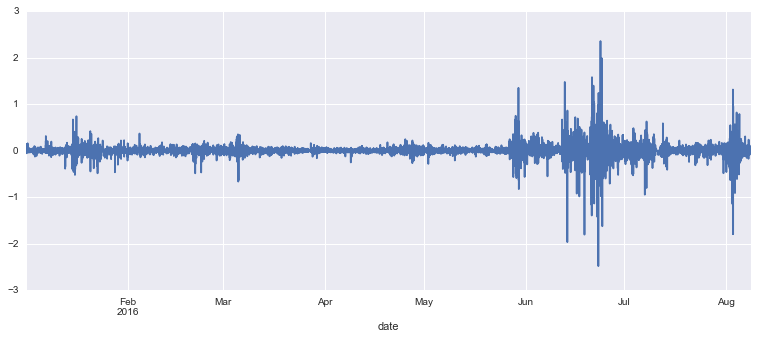

In [18]:
#take a look at the smoothed data, not much difference
df_diff.price_delta.rolling(window=20, center=False).median().plot(figsize=(13, 5))

In [19]:
#function to drop lags if we want to predict farther out
#but still use small time periods
def drop_lags(ts, lags):
    ts_drop = pd.DataFrame(ts, index = ts.index)
    for lag in xrange(1, lags):
        ts_drop = ts_drop.drop("Lag%d" % lag, axis = 1)
        
    return ts_drop
        
    

In [20]:
y_c = df_diff['Direction'] # for classification
#exog and endog
X = df_diff.drop("Direction", axis = 1)
X = X.drop('price_delta', axis = 1)
y = df_diff['price_delta'] # for regression 


# The test data is split into two parts
start_test = datetime.datetime(2016,6,1)

# Create training and test sets
X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]
y_c_train = y_c[y_c.index < start_test]
y_c_test = y_c[y_c.index >= start_test]

In [21]:
#check the correlation matrix
X_train.corr()

,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10
Lag1,1.000000,0.142226,0.052070,-0.012691,-0.024236,-0.009436,-0.017278,-0.020353,-0.007044,0.002458
Lag2,0.142226,1.000000,0.142223,0.052057,-0.012679,-0.024221,-0.009453,-0.017268,-0.020348,-0.007041
Lag3,0.052070,0.142223,1.000000,0.142225,0.052063,-0.012673,-0.024224,-0.009452,-0.017266,-0.020347
Lag4,-0.012691,0.052057,0.142225,1.000000,0.142248,0.052084,-0.012681,-0.024220,-0.009449,-0.017264
Lag5,-0.024236,-0.012679,0.052063,0.142248,1.000000,0.142247,0.052096,-0.012688,-0.024223,-0.009450
Lag6,-0.009436,-0.024221,-0.012673,0.052084,0.142247,1.000000,0.142262,0.052088,-0.012693,-0.024226
Lag7,-0.017278,-0.009453,-0.024224,-0.012681,0.052096,0.142262,1.000000,0.142271,0.052093,-0.012690
Lag8,-0.020353,-0.017268,-0.009452,-0.024220,-0.012688,0.052088,0.142271,1.000000,0.142269,0.052092
Lag9,-0.007044,-0.020348,-0.017266,-0.009449,-0.024223,-0.012693,0.052093,0.142269,1.000000,0.142268
Lag10,0.002458,-0.007041,-0.020347,-0.017264,-0.009450,-0.024226,-0.012690,0.052092,0.142268,1.000000


In [22]:
# run Linear, test
brr = LinearRegression()
scores = -cross_validation.cross_val_score(brr, X_train, y_train, cv=5,  scoring ="mean_squared_error")
print scores

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


[ 0.07437288  0.02863986  0.02816664  0.01738191  0.08729346]


In [23]:
brr = BayesianRidge()
scores = cross_validation.cross_val_score(brr, X_train, y_train, cv=5,  scoring ="r2")
print scores

[ 0.03574665  0.04106237  0.02818223  0.02353468 -0.04550691]


In [24]:
brr = BayesianRidge()
brr.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [25]:
brr_p = brr.predict(X_test)

print metrics.mean_absolute_error(y_test, brr_p)
print metrics.mean_squared_error(y_test, brr_p)
print metrics.explained_variance_score(y_test, brr_p)
print metrics.r2_score(y_test, brr_p)

0.282341486995
0.440225438573
0.0261939350925
0.0261938857105


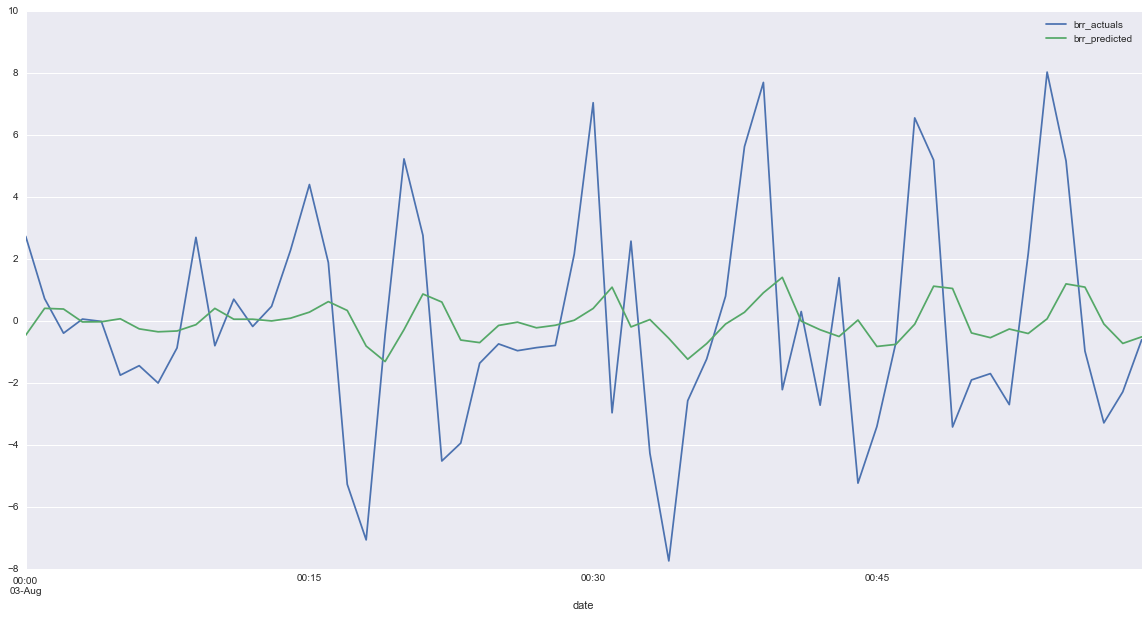

In [26]:
brr_predicted = pd.Series(brr_p, index = y_test.index)
brr_actuals = pd.Series(y_test)

df_plot = pd.DataFrame()
df_plot['brr_actuals'] = brr_actuals
df_plot['brr_predicted'] = brr_predicted
df_plot.loc[(df_plot.index.year==2016)&(df_plot.index.month==8)\
            &(df_plot.index.day==3)&(df_plot.index.hour==0)].plot(figsize=(20, 10))

In [27]:
df_plot.tail()

,brr_actuals,brr_predicted
date,,
2016-08-08 11:56:00,0.010000,-0.016777
2016-08-08 11:57:00,0.023333,-0.000785
2016-08-08 11:58:00,0.010000,0.004584
2016-08-08 11:59:00,0.003333,0.001995
2016-08-08 12:00:00,-0.056667,-0.001783


In [28]:
# now check class error by transforming
def class_transform(df):
    df2 = pd.DataFrame(df)
    df2["Direction_act"] = np.sign(df2["brr_actuals"])
    df2["Direction_pred"] = np.sign(df2["brr_predicted"])
    return df2

In [29]:
df_reg2class = class_transform(df_plot)

In [30]:
df_reg2class.head()

,brr_actuals,brr_predicted,Direction_act,Direction_pred
date,,,,
2016-06-01 00:00:00,-0.355333,-0.027528,-1.0,-1.0
2016-06-01 00:01:00,-0.454926,-0.062241,-1.0,-1.0
2016-06-01 00:02:00,-0.233254,-0.074171,-1.0,-1.0
2016-06-01 00:03:00,0.119704,-0.039377,1.0,-1.0
2016-06-01 00:04:00,-0.106025,0.016246,-1.0,1.0


In [31]:
print metrics.classification_report(df_reg2class.Direction_act,\
                                    df_reg2class.Direction_pred)
print metrics.accuracy_score(df_reg2class.Direction_act,\
                                    df_reg2class.Direction_pred)

             precision    recall  f1-score   support

       -1.0       0.43      0.48      0.45     41450
        1.0       0.59      0.55      0.57     57191

avg / total       0.52      0.52      0.52     98641

0.517867823724


In [ ]:
#not too good! Better results using the non-differenced data because of the
#high autocorrelation
